# 4 训练Transformer LM
我们现在已经有了通过分词器预处理数据和模型（Transformer）的步骤。接下来需要完成支持训练的所有代码，主要包括以下部分：
* 损失函数：需要定义损失函数（交叉熵）。
* 优化器：需要定义用于最小化该损失的优化器（AdamW）。
* 训练循环：需要构建所有支持性的基础设施，包括加载数据、保存检查点以及管理训练过程。

## 4.1 交叉熵损失

[“交叉熵”如何做损失函数？打包理解“信息量”、“比特”、“熵”、“KL散度”、“交叉熵”](https://www.bilibili.com/video/BV15V411W7VB/?share_source=copy_web&vd_source=c379ccdab784832c917bb852fa2b0584)

长度为 $m$ 的token序列组成一个训练集 $D$，此时定义分布概率 $p_\theta (x_{i+1} \mid x_{1:i})$ 表示在给定序列 $x$ 的前 $i$ 个元素 $x_{1:i}$ 条件下，模型预测下一个元素 $x_{i+1}$ 的概率(**正确率**)。

我们定义标准的交叉熵（负对数似然）损失函数：
$$\ell (\theta ; D)=\frac{1}{|D|m}\sum_{x \in D}\sum_{i=1}^{m}-\log p_\theta (x_{i+1} \mid x_{1:i})$$

* $\frac{1}{|D|m}$ 是一个归一化因子。其中 $|D|$ 表示训练集中序列 $D$ 的数量，$m$ 表示每个序列的长度。通过除以 $|D|m$，可以将整个训练集上的损失进行平均，使得不同规模训练集的损失具有可比性。

（注意：Transformer 的一次前向传播可以得到所有 $i$ 对应的 $p_{\theta}(x_{i+1} \mid x_{1:i})$ 。）

具体的：
$$
p(x_{i+1} \mid x_{1:i}) = \text{softmax}(o_i)[x_{i+1}] = \frac{\exp(o_i[x_{i+1}])}{\sum_{a=1}^{\text{vocab\_ size}} \exp(o_i[a])}
$$

* Transfomer 为每个位置计算 logits 向量 $o_i \in \mathbb{R}^{\text{vocab\_size}}$
* $\text{softmax}(o_i)[x_{i+1}]$ 表示 softmax 作用于 $o_i$ 向量，并取向量中的 $x_{i+1}$ 对应的概率值


实现交叉熵损失时需要特别注意数值稳定性问题，这一点与 softmax 的实现类似。



#### 问题（cross_entropy）：实现交叉熵损失
交付内容：编写一个函数来计算交叉熵损失，该函数接收预测的 logits（$o_i$）和目标值（$x_{i+1}$），并计算交叉熵 $\ell_i = −\log \mathbf{softmax}(o_i)[x_{i+1}]$。你的函数应满足以下要求：

* 减去最大值以保证数值稳定性。
* 尽可能约去 $\log$ 和 $\exp$ 运算，避免数值溢出或下溢。
* 能够处理任意的批量（batch）维度，并对 batch 维度求平均后返回结果。
与第 3.3 节一样，我们假设批量相关的维度始终位于词汇表维度（vocab_size）之前。

In [ ]:
import torch


def softmax(x: torch.Tensor, dim: int) -> torch.Tensor:
    """
    Args:
        x: 输入张量 (batch_size, vocab_size)
    
    数值稳定的 softmax 实现
    通过减去最大值防止 exp 溢出
    """

    # x_max (batch_size, 1) 
    x_max = x.max(dim=dim, keepdim=True)[0]  # 防止 exp(x) 上溢 
    x_exp = torch.exp(x - x_max)  # 稳定的指数计算
    return x_exp / x_exp.sum(dim=dim, keepdim=True)  # 归一化到概率分布


class CrossEntropyLoss:
    def __init__(self, inputs:torch.Tensor, targets:torch.LongTensor):
        """
        Args:
            logits: (..., vocab_size)
            targets: (..., ) 真实标签索引

        初始化交叉熵损失计算器
        """
        self.inputs = inputs  # 模型输出的原始 logits
        self.targets = targets  # 真实标签索引 (long tensor)
        self.vocab_size = inputs.shape[1]  # 词汇表大小
        self.batch_size = inputs.shape[0]  # 批次大小

    def forward(self):
        """
        前向计算交叉熵损失
        步骤：softmax -> 取真实类概率 -> 负对数求和
        """
        y_pred = softmax(self.inputs, dim=1)  # 对每行做 softmax 得预测概率

        # 提取真实标签对应的概率 p = y_pred[i, targets[i]]
        p = y_pred[range(self.batch_size), self.targets]

        # 计算负对数似然并求和
        return -torch.sum(torch.log(p))

困惑度（Perplexity）是另一个评估模型的参数。

对于一个长度为 $m$ 的序列，对应的交叉熵损失 $\ell_i$ 有:
$$\text{perplexity} = \exp\left(\frac{1}{m} \sum_{i=1}^m \ell_i\right).$$

## 4.2 随机梯度下降优化器 (SGD)
现在我们有了损失函数，接下来将开始探索优化器。最简单的基于梯度的优化器是随机梯度下降（SGD）。我们从随机初始化的参数 $\theta_0$ 开始。然后对于每一步 $t = 0, \ldots, T - 1$，执行以下更新：

$$\theta_{t+1} \leftarrow \theta_t - \alpha_t \nabla L(\theta_t; B_t)$$

其中 $B_t$ 是从数据集 $D$ 中采样的随机批量数据，学习率 $\alpha_t$ 和批量大小 $|B_t|$ 是超参数。

### 4.2.1 Pytorch 中实现SGD
要实现我们的优化器，我们将继承 PyTorch 的 `torch.optim.Optimizer` 类。一个 `Optimizer` 子类必须实现两个方法：

* `def __init__(self, params, ...)` params 将需要优化的参数集合（或参数组，如果用户想为模型的不同部分使用不同的超参数，例如不同的学习率）。确保将 params 传递给基类的 `__init__` 方法，该方法会将这些参数存储起来以供后续使用。你可以添加额外的参数（例如学习率），并将它们作为字典传递给基类构造函数。
* `def step(self)` 执行一次参数更新。在训练循环中，这个方法会在**反向传播**后被调用，因此你可以访问到上一批数据的梯度遍历每个参数张量 `p.grad` 并修改

假设从一个初始学习率 $\alpha$ 开始，有如下迭代过程：
$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{t + 1}} \nabla L(\theta_t; B_t) $$

这是一个变体SGD：

我们将该版本实现为 Pytorch Optimizer



In [ ]:
from collections.abc import Callable, Iterable
from typing import Optional
from torch import nn
import torch
import math


class SGD(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3):
        """
        简易SGD优化器，学习率按 sqrt(t+1) 衰减
        """
        if lr < 0:
            raise ValueError(f"Invalid learning rate: {lr}")
        defaults = {"lr": lr}
        super().__init__(params, defaults)

    def step(self, closure: Optional[Callable] = None):
        """
        执行一次参数更新
        支持可选的闭包函数用于重新计算模型
        """
        loss = None if closure is None else closure()

        for group in self.param_groups:
            lr = group["lr"]  # 当前参数组的学习率

            p:nn.Parameter
            for p in group["params"]:
                if p.grad is None:
                    continue
                # 获取参数状态（用于记录迭代次数）
                state: dict[str, any] = self.state[p]
                step_count = state.get("step_count", 0)  # 读取当前步数，初始为0

                #Tensor 与 Tensor.data 区别在于 Tensor.data 不会被 autograd 追踪
                #!不安全：使用 .data 可能引起梯度历史不一致或难以发现的 bug，尤其在复杂训练/微分操作中会导致问题
                #grad: torch.Tensor = p.grad.data  # 梯度数据

                # 更新参数：权重衰减因子为 1/sqrt(step_count + 1)
                #p.data -= lr / math.sqrt(step_count + 1) * grad

                # 推荐（安全，不会追踪到 autograd）
                with torch.no_grad():
                    p -= lr / math.sqrt(step_count + 1) * p.grad

                # 步数递增并保存回状态
                state["step_count"] = step_count + 1

        return loss


# ------------------- 测试代码 -------------------
weights = torch.nn.Parameter(5 * torch.randn((10, 10)))  # 初始化可学习参数
opt = SGD([weights], lr=1)  # 创建优化器

print("Initial weights shape:", weights.shape)
for t in range(100):
    opt.zero_grad()  # !清零梯度
    loss = (weights**2).mean()  # 定义目标：最小化权重平方均值
    print(loss.cpu().item())  # 打印当前损失
    loss.backward()  # 反向传播计算梯度
    opt.step()  # 更新参数

Initial weights shape: torch.Size([10, 10])
tensor(23.8863, grad_fn=<MeanBackward0>)
23.88629722595215
22.940401077270508
22.29613494873047
21.784198760986328
21.350692749023438
20.970468521118164
20.62942123413086
20.31871223449707
20.032381057739258
19.766172409057617
19.516935348510742
19.282262802124023
19.060253143310547
18.849388122558594
18.648414611816406
18.45631217956543
18.2722110748291
18.095375061035156
17.9251708984375
17.761056900024414
17.60255241394043
17.44923973083496
17.300748825073242
17.156753540039062
17.01695442199707
16.881092071533203
16.748926162719727
16.620241165161133
16.494840621948242
16.372547149658203
16.253198623657227
16.136638641357422
16.02273941040039
15.911364555358887
15.80240249633789
15.695738792419434
15.59127426147461
15.488916397094727
15.388571739196777
15.290164947509766
15.193614959716797
15.098847389221191
15.0058012008667
14.914406776428223
14.824604034423828
14.736340522766113
14.649557113647461
14.564208984375
14.480243682861328
14.3

## 4.3 AdamW
现代语言模型通常使用比SGD更复杂的优化器进行训练。最近广泛使用的优化器大多源自Adam优化器 [Kingma 和 Ba, 2015]。我们将使用AdamW [Loshchilov 和 Hutter, 2019]，这是近期研究中广泛采用的一种优化器。AdamW对Adam进行了改进，通过引入权重衰减（在每次迭代中将参数向0拉近）来提升正则化效果，并且该权重衰减与梯度更新解耦。我们将按照Loshchilov和Hutter [2019]论文中算法2的描述来实现AdamW。

AdamW 是有状态的：对每个参数，它会维护其一阶和二阶矩的滑动估计值。因此，AdamW 以额外的内存消耗为代价，换取了更好的训练稳定性和收敛性。除了学习率 α 外，AdamW 还包含一对控制矩估计更新的超参数 (β₁, β₂)，以及一个权重衰减率 λ。通常情况下，(β₁, β₂) 设为 (0.9, 0.999)，但像 LLaMA [Touvron 等, 2023] 和 GPT-3 [Brown 等, 2020] 这样的大语言模型通常使用 (0.9, 0.95)。该算法可表述如下，其中 ϵ 是一个很小的值（例如 10⁻⁸），用于在 v 出现极小值时提升数值稳定性：

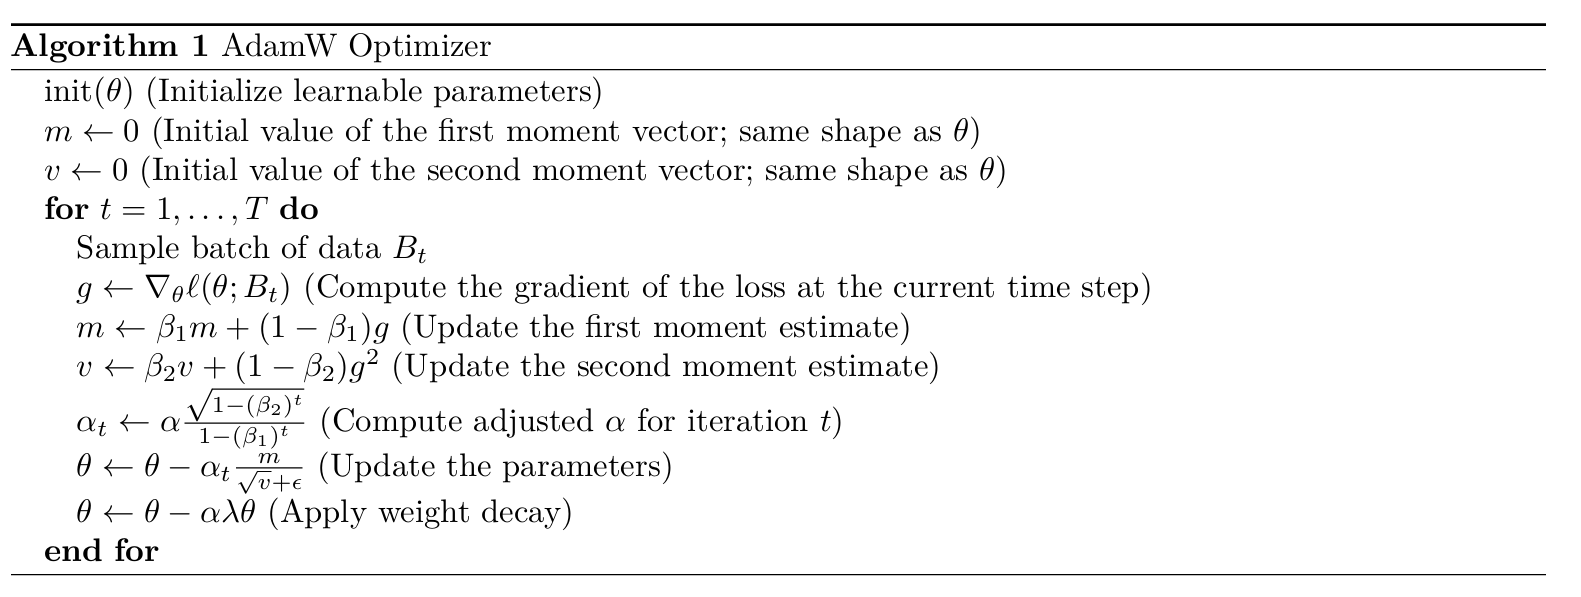

#### 问题（adamw）：实现 AdamW
提交要求：将 AdamW 优化器实现为 torch.optim.Optimizer 的子类。你的类在 `__init__` 中应接收学习率 α，以及超参数 β₁、β₂、ϵ 和 λ。为了帮助你维护状态，基类 Optimizer 提供了一个字典 self.state，它将 nn.Parameter 对象映射到一个字典，用于存储该参数所需的任何信息（对 AdamW 而言，即一阶和二阶矩估计值）。

In [5]:
from typing import Optional, Callable, Any
from torch import optim
import torch


class AdamW(optim.Optimizer):
    def __init__(
        self,
        params,
        lr: float,
        betas: tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-8,
        weight_decay: float = 0.0,
    ):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

    def step(self, closure: Optional[Callable] = None):
        """
        Simple AdamW implementation.
        """
        loss = None if closure is None else closure()

        for group in self.param_groups:
            p: nn.Parameter
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad  # use clean grad tensor
                state:dict[str,any]= self.state[p]

                # 初始化状态缓存：step, 变量 m, RMS v
                if len(state) == 0:
                    state["step"] = 0
                    state["m"] = torch.zeros_like(p)  # 一阶矩估计
                    state["v"] = torch.zeros_like(p)  # 二阶矩估计

                m, v = state["m"], state["v"]
                beta1, beta2 = group["betas"]

                state["step"] += 1

                # 更新变量：m = beta1 * m + (1 - beta1) * grad
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                # 更新 RMS：v = beta2 * v + (1 - beta2) * grad^2
                v.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # 偏差修正系数
                bias_correction1 = 1 - beta1 ** state["step"]
                bias_correction2 = 1 - beta2 ** state["step"]
                step_size = group["lr"] / bias_correction1

                # 分母：sqrt(v / bias_correction2) + eps
                denom = (v / bias_correction2).sqrt().add_(group["eps"])
                # 在 no_grad 环境中更新参数（避免 autograd 跟踪）
                with torch.no_grad():
                    p.addcdiv_(-step_size, m, denom)
                    # 解耦权重衰减（直接作用于参数，不通过梯度）
                    p.add_(p, alpha=-group["weight_decay"] * group["lr"])
        return loss

#### 问题（adamwAccounting）：使用 AdamW 训练的资源核算
让我们计算运行 AdamW 所需的内存和计算量。假设所有张量均使用 float32（每个元素占 4 字节）。

*  运行 AdamW 所需的峰值内存是多少？请根据参数、激活值（activations）、梯度和优化器状态的内存使用情况分解回答。用 batch_size 和模型超参数（vocab_size、context_length、num_layers、d_model、num_heads）表示你的答案。假设 d_ff = 4 × d_model。
>为简化激活值的内存计算，仅考虑以下组件：
>* Transformer 块：
>* * RMSNorm(s)
>* * 多头自注意力子层：QKV 投影、QᵀK 矩阵乘法、softmax、加权求和（value 加权和）、输出投影
>* 位置前馈网络（FFN）：W1 矩阵乘法、SiLU 激活、W2 矩阵乘法
>* 最终的 RMSNorm
>* 输出嵌入（output embedding）
>* logits 上的交叉熵损失


提交要求：分别给出参数、激活值、梯度和优化器状态的代数表达式，以及总内存的表达式。



[AdamW内存与计算资源计算器](./data/compute.html)

注意：此处假设**d_ff = 4 × d（前馈层隐藏维度）**

$$[ \text{参数数量:} \quad P = 2Vd + L(12d^2+2d) + d ] \\
 [ \text{激活数量:} \quad A_{total} = L(16Nd + 2BhT^2) + Nd + 2NV ]\\
  [ \text{内存分解(float32):} \quad Mem_{param} = 4P, \quad Mem_{grad} = 4P, \quad Mem_{opt} = 8P, \quad Mem_{act} = 4A_{total} ]\\
   [ \text{峰值:} \quad Mem_{peak} = 16P + 4A_{total} \quad (\text{bytes}) ]$$

## 4.4 学习率调度
导致损失最快减少的学习率值在训练过程中常常会发生变化。在训练 Transformer 模型时，通常采用学习率调度策略：先使用较大的学习率，在训练初期进行更快速的更新，再随着模型的训练逐渐将其衰减至较小的值。在本作业中，我们将实现用于训练 LLaMA 的余弦退火调度策略 [Touvron et al., 2023]。

调度器本质上是一个函数，它接收当前步数 t 和其他相关参数（如初始学习率和最终学习率），并返回在第 t 步梯度更新时应使用的学习率。最简单的调度器是常函数，它会针对任意 t 返回相同的学习率。
余弦退火学习率调度器需要以下输入：
1) 当前迭代次数 $t$ ，
2) 最大学习率  $\alpha_{max}$
3) 最小（最终）学习率  $\alpha_{min}$
4) 预热迭代次数  $T_w$
5) 以及余弦退火迭代次数 $T_c$
  
第  $t$  次迭代时的学习率定义如下：

* **预热阶段**：若 $t<T_w ,$ 则  $\alpha_t = \frac{t}{T_w} \alpha_{\max}$
* **余弦退火阶段**：若$T_w \leq t \leq T_c$ 则$\alpha_t = \alpha_{\min} + \frac{1}{2} \left( 1 + \cos \left( \frac{t - T_w}{T_c - T_w} \pi \right) \right) (\alpha_{\max} - \alpha_{\min})$
* **退火后阶段**：若  $t>t_c ,$ 则 $\alpha_t =\alpha_{min}$

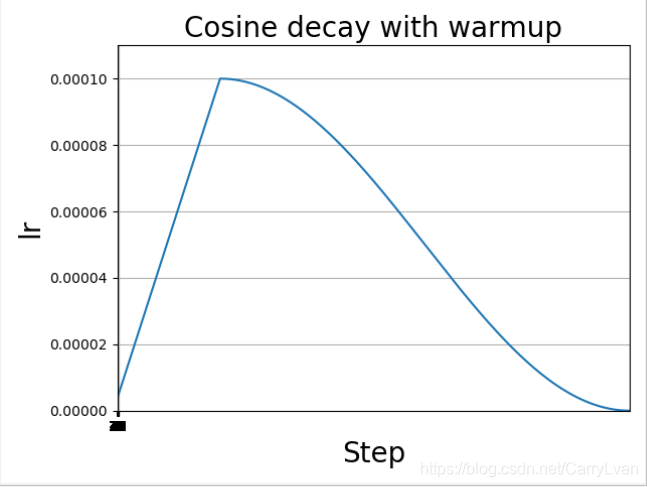

#### 问题（learning_rate_schedule）：实现带预热的余弦学习率调度
编写一个函数，该函数接收参数 $t$（当前训练步数）、$\alpha_{max}$（最大学习率）、$\alpha_{min}$（最小学率）、$T_w$（预热步数）和 $T_c$（总训练步数），并根据上述定义的学习率调度策略返回当前步数对应的学习率 $\alpha_t$。

In [ ]:
import math


class CosineSchedule:
    """
    实现带 warmup 的余弦退火学习率调度器
    学习率变化分为三个阶段：
    1. Warmup 阶段：从 0 线性上升到最大学习率
    2. Cosine 衰减阶段：从最大学习率按余弦函数下降到最小学习率
    3. 持平阶段：保持最小学习率不变
    """

    def __init__(
        self, max_learning_rate, min_learning_rate, warmup_iters, cosine_cycle_iters
    ):
        """
        初始化余弦学习率调度器

        Args:
            max_learning_rate (float): 最大学习率（warmup 结束时达到的值）
            min_learning_rate (float): 最小学习率（余弦衰减结束时的值）
            warmup_iters (int): warmup 阶段的迭代次数
            cosine_cycle_iters (int): 余弦衰减周期的总迭代次数（从 warmup 结束到周期结束）
        """
        self.max_learning_rate = max_learning_rate  # 不修改大变量名
        self.min_learning_rate = min_learning_rate
        self.warmup_iters = warmup_iters
        self.cosine_cycle_iters = cosine_cycle_iters

    def __call__(self, current_iter):
        """
        根据当前迭代次数计算对应的学习率

        Args:
            current_iter (int): 当前训练的迭代次数（从 0 开始）

        Returns:
            float: 该迭代次数对应的学习率值
        """
        # 阶段 1：Warmup 阶段（线性增长）
        if current_iter < self.warmup_iters:
            # 从 0 线性增长到 max_learning_rate
            return self.max_learning_rate * current_iter / self.warmup_iters

        # 阶段 3：Cosine 衰减结束后，保持最小学习率
        elif current_iter > self.cosine_cycle_iters:
            return self.min_learning_rate

        # 阶段 2：余弦退火衰减阶段
        else:
            # 计算从 warmup 结束到当前的相对位置（归一化到 [0, 1]）
            progress = (current_iter - self.warmup_iters) / (
                self.cosine_cycle_iters - self.warmup_iters
            )
            # 余弦衰减公式：从 1 到 0 的余弦曲线，再线性映射到 [min_lr, max_lr]
            cosine_decay = (1 + math.cos(math.pi * progress)) / 2
            return (
                self.min_learning_rate
                + (self.max_learning_rate - self.min_learning_rate) * cosine_decay
            )

##  梯度裁剪
在训练过程中，我们有时会遇到产生较大梯度的训练样本，这可能会导致训练不稳定。为缓解这一问题，实践中常用的一种技术是梯度裁剪（gradient clipping）。其核心思想是在每次反向传播后，对梯度的范数施加一个上限。

给定所有参数的梯度 $g$，我们计算其  $\ell_2$-范数 $||g||_2$。如果该范数小于最大值 $M$，则保持 $g$ 不变；否则，我们将 $g$ 缩放因子为 $\frac{M}{\|g\|_2 + \epsilon}$
（其中添加了一个很小的 $\epsilon$，如$10^{-6}$，以确保数值稳定性）。注意，缩放后的范数将略小于 $M$。

#### 问题（gradient_clipping）：实现梯度裁剪（1 分）
编写一个函数来实现梯度裁剪。你的函数应该`接收一组参数和一个最大
$\ell_2$-范数，并就地修改每个参数的梯度。使用$\epsilon = 10^{-6}$
（这是 PyTorch 的默认值）。

In [ ]:
import torch

class GradientClip:
    """实现全局梯度L2范数裁剪的工具类"""
    
    def __init__(self, parameters:nn.Parameter, max_l2_norm, epsilon=1e-6):
        """
        初始化梯度裁剪器
        
        Args:
            parameters: 需要裁剪梯度的模型参数列表
            max_l2_norm: 允许的最大全局L2范数值
            epsilon: 防止除零的小常数（默认1e-6）
        """
        self.parameters = parameters 
        self.max_l2_norm = max_l2_norm  
        self.epsilon = epsilon  

    def __call__(self):
        """执行梯度裁剪操作（原地修改梯度）"""
        # 1. 收集所有有效梯度（跳过无梯度的参数）
        valid_gradients = [p.grad for p in self.parameters if p.grad is not None]
        
        # 2. 将所有梯度展平并拼接成单一向量（计算全局范数需要）
        flattened_grads = torch.cat([grad.flatten() for grad in valid_gradients])
        
        # 3. 计算全局L2范数（所有梯度的欧氏距离）
        total_norm = torch.norm(flattened_grads, 2)
        
        # 4. 仅当范数超过阈值时执行裁剪
        if total_norm > self.max_l2_norm:
            # 计算裁剪系数（添加epsilon防止除零）
            clip_coeff = self.max_l2_norm / (total_norm + self.epsilon)
            
            # 5. 对所有梯度进行原地缩放
            for grad in valid_gradients:
                grad.mul_(clip_coeff)  # 等价于 grad = grad * clip_coeff